# Try to understand why precipitation is causing convection (or not)

In [1]:
import xarray as xr
import numpy as np
import cmocean
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import sys
sys.path.append('/home/users/birgal/')
import pickle
from nemo_python_git.utils import fix_lon_range, dewpoint_to_specific_humidity
from nemo_python_git.interpolation import regrid_array_cf, regrid_operator_cf, interp_latlon_cf, construct_cf, regrid_era5_to_cesm2
from nemo_python_git.file_io import find_cesm2_file, find_processed_cesm2_file
from nemo_python_git.constants import cesm2_ensemble_members, sec_per_day, sec_per_hour, rho_fw
from nemo_python_git.forcing import cesm2_ensemble_time_mean_forcing

/home/users/birgal/.conda/envs/cf-env/lib/python3.12/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


## Look at raw files
- 2D fields of annual total precipitation for 1979: CESM2 raw files, CESM2 processed files, ERA5 daily files, ERA5 hourly files, other ERA5 daily files
- at some point do the same for snowfall

In [32]:
cesm2_LE2_raw_dir  = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/climate-forcing/CESM2/LE2/'
cesm2_LE2_proc_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/climate-forcing/CESM2/LE2/processed/'
cesm2_piC_raw_dir  = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/climate-forcing/CESM2/piControl/'
cesm2_piC_proc_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/climate-forcing/CESM2/piControl/processed/'

cesm2_LE2_raw  = xr.open_dataset(f'{cesm2_LE2_raw_dir}b.e21.BHISTsmbb.f09_g17.LE2-1011.001.cam.h1.PRECT.18500101-18591231.nc').sel(lat=slice(-90,-50)).isel(time=slice(0,365)).PRECT
cesm2_LE2_proc = xr.open_dataset(f'{cesm2_LE2_proc_dir}CESM2-LE2_ens1011.001_PRECT_y1850.nc').sel(lat=slice(-90,-50)).PRECT
cesm2_piC_raw  = xr.open_dataset(f'{cesm2_piC_raw_dir}b.e21.B1850.f09_g17.CMIP6-piControl.001.cam.h1.PRECT.18500101-18591231.nc').sel(lat=slice(-90,-50)).isel(time=slice(0,365)).PRECT
cesm2_piC_proc = xr.open_dataset(f'{cesm2_piC_proc_dir}CESM2-piControl_ens001_PRECT_y1850.nc').sel(lat=slice(-90,-50)).PRECT
cesm2_LE2_raw['lon'] = fix_lon_range(cesm2_LE2_raw['lon'])
cesm2_piC_raw['lon'] = fix_lon_range(cesm2_piC_raw['lon'])

cesm2_LE2_raw  = cesm2_LE2_raw.sortby('lon')
cesm2_LE2_proc = cesm2_LE2_proc.sortby('lon')
cesm2_piC_raw  = cesm2_piC_raw.sortby('lon')
cesm2_piC_proc = cesm2_piC_proc.sortby('lon')

In [40]:
print((cesm2_LE2_raw.sum(dim='time')*rho_fw).sum().values)
print((cesm2_LE2_proc.sum(dim='time')).sum().values)
print((cesm2_piC_raw.sum(dim='time')*rho_fw).sum().values)
print((cesm2_piC_proc.sum(dim='time')).sum().values)

76.38368
76.38368
77.80687
77.80688


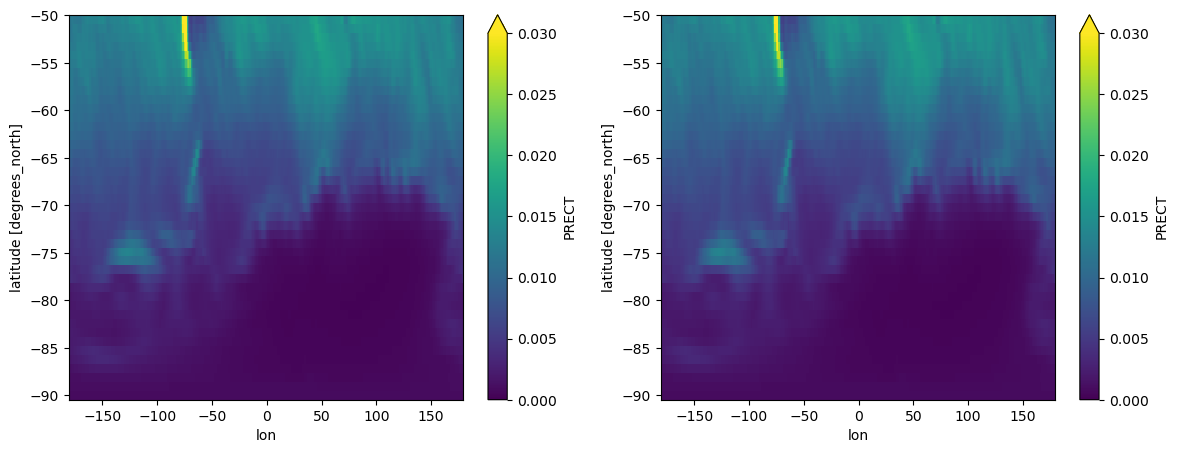

In [30]:
fig, ax = plt.subplots(1,2, figsize=(14,5))
(cesm2_LE2_raw.sum(dim='time')*rho_fw).plot(ax=ax[0], vmin=0, vmax=0.03)
(cesm2_LE2_proc.sum(dim='time')).plot(ax=ax[1], vmin=0, vmax=0.03)

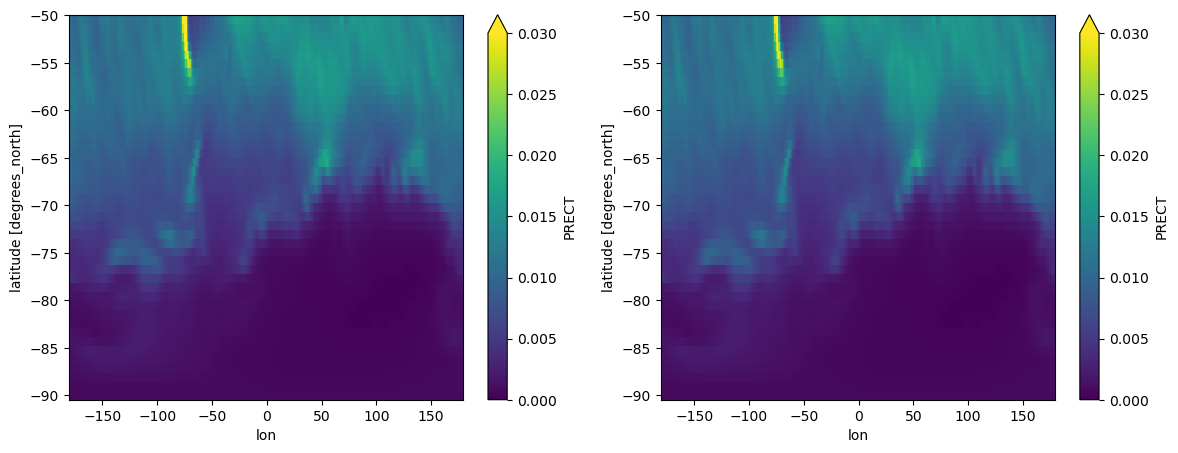

In [27]:
fig, ax = plt.subplots(1,2, figsize=(14,5))
(cesm2_piC_raw.sum(dim='time')*rho_fw).plot(ax=ax[0], vmin=0, vmax=0.03)
(cesm2_piC_proc.sum(dim='time')).plot(ax=ax[1], vmin=0, vmax=0.03)

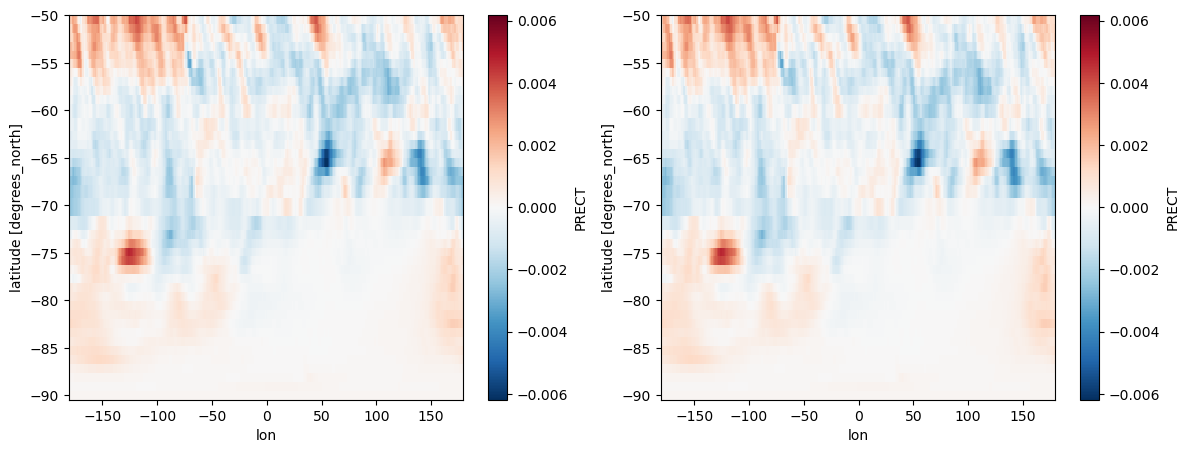

In [31]:
fig, ax = plt.subplots(1,2, figsize=(14,5))
(cesm2_LE2_raw.sum(dim='time')*rho_fw - cesm2_piC_raw.sum(dim='time')*rho_fw).plot(ax=ax[0])
(cesm2_LE2_proc.sum(dim='time') - cesm2_piC_proc.sum(dim='time')).plot(ax=ax[1])

#### Look at the seasonal variations

### Compare with the rainfall actually seen by the model (SBC output file)

In [56]:
LE2_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/output/CESM2-present-day6/files/'
piC_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/output/CESM2-piControl_test1/files/'

In [71]:
LE2_ds = xr.open_dataset(f'{LE2_dir}eANT025.L121_1m_18500101_18501231_SBC.nc')
piC_ds = xr.open_dataset(f'{piC_dir}eANT025.L121_1m_18500101_18501231_SBC.nc')

/tmp/ipykernel_861/73898949.py:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[1].pcolormesh(LE2_ds.nav_lon_grid_T.values, LE2_ds.nav_lat_grid_T.values, LE2_ds.precip.isel(time_counter=0).values, vmin=0, vmax=1e-4)


(-180.0, 180.0)

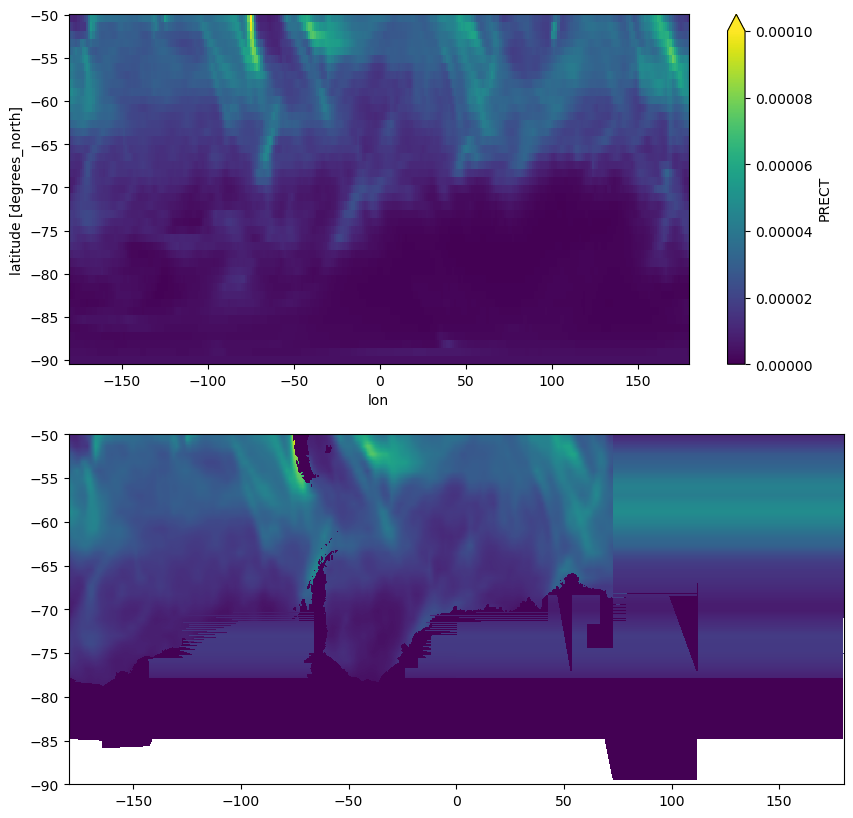

In [72]:
fig, ax = plt.subplots(2,1, figsize=(10,10))
(cesm2_LE2_proc.isel(time=slice(0,31)).mean(dim='time')).plot(ax=ax[0], vmin=0, vmax=1e-4)
ax[1].pcolormesh(LE2_ds.nav_lon_grid_T.values, LE2_ds.nav_lat_grid_T.values, LE2_ds.precip.isel(time_counter=0).values, 
                 vmin=0, vmax=1e-4)
ax[1].set_ylim(-90,-50)
ax[1].set_xlim(-180,180)
# (LE2_ds.precip.isel(time_counter=0)).plot(ax=ax[1], vmin=0, vmax=1e-4)

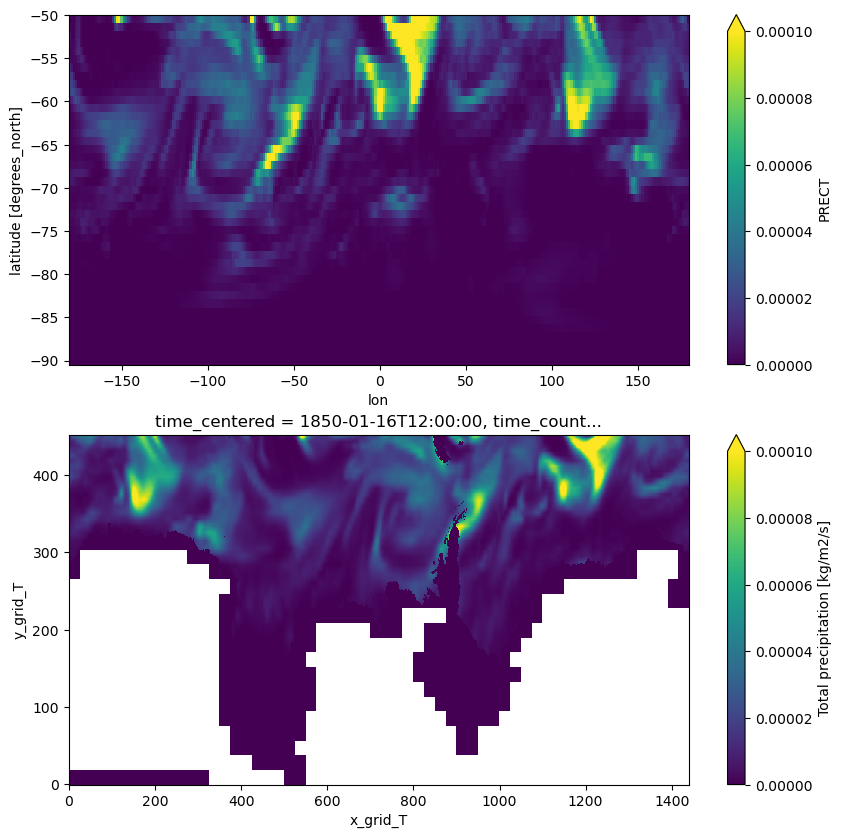

In [73]:
fig, ax = plt.subplots(2,1, figsize=(10,10))
(cesm2_piC_proc.isel(time=slice(0,1)).mean(dim='time')).plot(ax=ax[0], vmin=0, vmax=1e-4)
(piC_ds.precip.isel(time_counter=0)).plot(ax=ax[1], vmin=0, vmax=1e-4)

So, the model is clearly not seeing the precipitation that it should in the pre-industrial runs. I think it probably just keeps seeing day=1 for the entire month. That's true! It's because I'm telling it that PRECT is monthly while it's daily; only PRECS is monthly. 